# PFDA project

***

Weather data from [MET Eireann Historical Data](https://www.met.ie/climate/available-data/historical-data).

In [58]:
# import plotting library
import matplotlib.pyplot as plt

# import data analysis library
import pandas as pd

# import statistical library
import seaborn as sns

# import predictive data analysis tools
from sklearn.linear_model import LinearRegression

import numpy as np

import geopandas as gpd

import matplotlib.offsetbox as offsetbox
import matplotlib.image as mpimg

In [42]:
# data sources (monthly)
donegal_data_url = "https://cli.fusio.net/cli/climate_data/webdata/mly1575.csv" # Malin Head 2009-
cork_data_url = "https://cli.fusio.net/cli/climate_data/webdata/mly775.csv"     # Sherkin Island 2004-
dublin_data_url = "https://cli.fusio.net/cli/climate_data/webdata/mly3723.csv"  # Casement 1944-
galway_data_url = "https://cli.fusio.net/cli/climate_data/webdata/mly275.csv"   # Macehead 2003-
carlow_data_url = "https://cli.fusio.net/cli/climate_data/webdata/mly375.csv"   # Oak Park 2003-

In [43]:
# load the data from the urls into DataFrames
donegal_df = pd.read_csv(donegal_data_url, skiprows=18, low_memory=False)
cork_df = pd.read_csv(cork_data_url, skiprows=18, low_memory=False)
dublin_df = pd.read_csv(dublin_data_url, skiprows=18, low_memory=False)
galway_df = pd.read_csv(galway_data_url, skiprows=18, low_memory=False)
carlow_df = pd.read_csv(carlow_data_url, skiprows=18, low_memory=False)

In [44]:
donegal_df

,year,month,meant,maxtp,mintp,mnmax,mnmin,rain,gmin,wdsp,maxgt,sun
0,1955,5,9.5,20.2,1.4,12.3,6.6,70.1,-0.6,14.6,48,250.1
1,1955,6,12.4,18.8,6.6,14.7,10.0,83.2,-0.3,12.9,58,124.0
2,1955,7,14.8,21.3,8.8,17.5,12.1,22.1,4.5,6.2,33,213.3
3,1955,8,15.8,27.1,9.5,18.7,12.9,27.3,5.6,8.1,47,140.9
4,1955,9,13.9,23.4,7.7,16.5,11.2,114.2,4.4,16.0,50,121.9
...,...,...,...,...,...,...,...,...,...,...,...,...
829,2024,6,12.2,22.9,6.2,14.7,9.8,60.9,2.3,14.4,43,
830,2024,7,13.7,21.0,7.7,16.3,11.2,71.8,5.2,11.5,42,
831,2024,8,14.5,21.7,9.9,17.2,11.8,181.3,5.0,15.9,47,
832,2024,9,12.8,22.8,6.8,15.0,10.5,58.1,3.7,13.6,46,


Select only year, month and windspeed columns from each dataframe. And rename wdsp columns to include location name.

In [45]:
donegal_wdsp_df = donegal_df[['year', 'month', 'wdsp']].copy()
donegal_wdsp_df.rename(columns={'wdsp': 'wdsp_donegal'}, inplace=True)

cork_wdsp_df = cork_df[['year', 'month', 'wdsp']].copy()
cork_wdsp_df.rename(columns={'wdsp': 'wdsp_cork'}, inplace=True)

dublin_wdsp_df = dublin_df[['year', 'month', 'wdsp']].copy()
dublin_wdsp_df.rename(columns={'wdsp': 'wdsp_dublin'}, inplace=True)

galway_wdsp_df = galway_df[['year', 'month', 'wdsp']].copy()
galway_wdsp_df.rename(columns={'wdsp': 'wdsp_galway'}, inplace=True)

carlow_wdsp_df = carlow_df[['year', 'month', 'wdsp']].copy()
carlow_wdsp_df.rename(columns={'wdsp': 'wdsp_carlow'}, inplace=True)

Merging dataframes:

- https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html#merge

This only works for two dataframes, For multiple dataframes, we have to call it several times.

In [46]:
# merge the datasets on both year and month
combined_wdsp_df = donegal_wdsp_df.merge(
    cork_wdsp_df, on=['year', 'month'], how='inner'
).merge(
    dublin_wdsp_df, on=['year', 'month'], how='inner'
).merge(
    galway_wdsp_df, on=['year', 'month'], how='inner'
).merge(
    carlow_wdsp_df, on=['year', 'month'], how='inner'
)

In [47]:
combined_wdsp_df

,year,month,wdsp_donegal,wdsp_cork,wdsp_dublin,wdsp_galway,wdsp_carlow
0,2004,5,10.8,9.7,6.9,12.3,6.2
1,2004,6,14.8,10.9,10.0,14.2,7.5
2,2004,8,12.0,10.5,7.5,12.2,6.5
3,2004,10,15.3,14.0,9.6,14.8,7.6
4,2004,11,15.3,10.4,9.1,14.2,6.2
...,...,...,...,...,...,...,...
233,2024,6,14.4,10.1,9.0,13.5,6.8
234,2024,7,11.5,9.6,8.1,11.7,6.1
235,2024,8,15.9,12.3,11.8,17.7,8.4
236,2024,9,13.6,10.4,8.4,12.2,6.2


Clean data a bit

In [48]:
# replace empty strings with NaN
#df = df.replace(["", " ", "NA", "null"], np.nan)

In [49]:
# check how many missing entries in each column
combined_wdsp_df.isna().sum()


year            0
month           0
wdsp_donegal    0
wdsp_cork       0
wdsp_dublin     0
wdsp_galway     0
wdsp_carlow     0
dtype: int64

In [50]:
combined_wdsp_df.dropna(inplace=True)

In [51]:
combined_wdsp_df.isna().sum()

year            0
month           0
wdsp_donegal    0
wdsp_cork       0
wdsp_dublin     0
wdsp_galway     0
wdsp_carlow     0
dtype: int64

In [52]:
# view the first row in the dataframe
combined_wdsp_df.iloc[0]

year            2004
month              5
wdsp_donegal    10.8
wdsp_cork        9.7
wdsp_dublin      6.9
wdsp_galway     12.3
wdsp_carlow      6.2
Name: 0, dtype: object

In [53]:
# view datatypes
combined_wdsp_df.dtypes

year             int64
month            int64
wdsp_donegal    object
wdsp_cork       object
wdsp_dublin     object
wdsp_galway     object
wdsp_carlow     object
dtype: object

Windseed isnt numeric. Convert entire df to numeric first.

In [54]:
# convert to all columns to numeric
combined_wdsp_df = combined_wdsp_df.apply(pd.to_numeric, errors='coerce')

In [55]:
# check df again
combined_wdsp_df.dtypes

year              int64
month             int64
wdsp_donegal    float64
wdsp_cork       float64
wdsp_dublin     float64
wdsp_galway     float64
wdsp_carlow     float64
dtype: object

In [56]:
# Combine 'year' and 'month' into a single 'date' column
combined_wdsp_df['date'] = pd.to_datetime(combined_wdsp_df[['year', 'month']].assign(day=1))

In [57]:
combined_wdsp_df

,year,month,wdsp_donegal,wdsp_cork,wdsp_dublin,wdsp_galway,wdsp_carlow,date
0,2004,5,10.8,9.7,6.9,12.3,6.2,2004-05-01
1,2004,6,14.8,10.9,10.0,14.2,7.5,2004-06-01
2,2004,8,12.0,10.5,7.5,12.2,6.5,2004-08-01
3,2004,10,15.3,14.0,9.6,14.8,7.6,2004-10-01
4,2004,11,15.3,10.4,9.1,14.2,6.2,2004-11-01
...,...,...,...,...,...,...,...,...
233,2024,6,14.4,10.1,9.0,13.5,6.8,2024-06-01
234,2024,7,11.5,9.6,8.1,11.7,6.1,2024-07-01
235,2024,8,15.9,12.3,11.8,17.7,8.4,2024-08-01
236,2024,9,13.6,10.4,8.4,12.2,6.2,2024-09-01


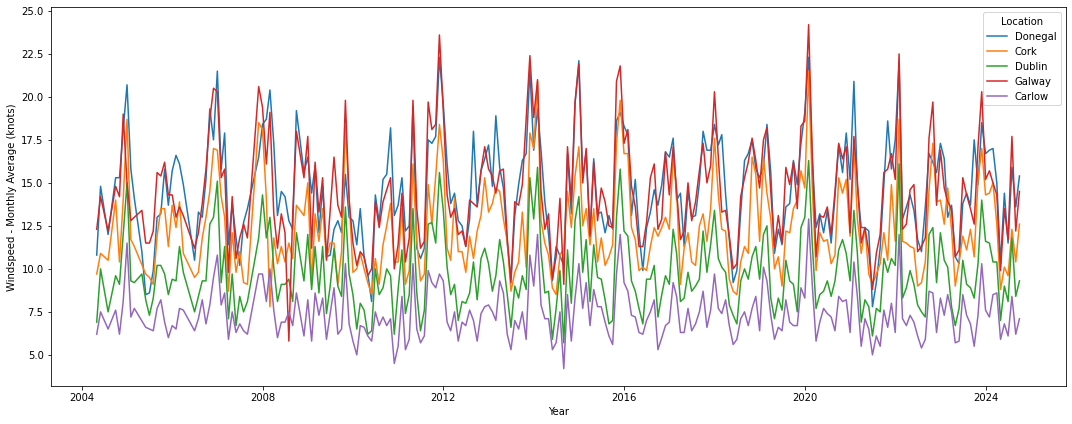

In [61]:
# plot line using seaborn
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(data=combined_wdsp_df, x='date', y='wdsp_donegal', label='Donegal')
sns.lineplot(data=combined_wdsp_df, x='date', y='wdsp_cork', label='Cork')
sns.lineplot(data=combined_wdsp_df, x='date', y='wdsp_dublin', label='Dublin')
sns.lineplot(data=combined_wdsp_df, x='date', y='wdsp_galway', label='Galway')
sns.lineplot(data=combined_wdsp_df, x='date', y='wdsp_carlow', label='Carlow')

# decorate the plot
plt.xlabel("Year")
plt.ylabel("Windspeed - Monthly Average (knots)")
#plt.title(f"wi")
plt.legend(title='Location')

plt.tight_layout()

### Predictive Stuff

scikit learn needs numeric columns, convert datetime to fractional years first.

In [62]:
# convert 'date' to numeric (fractional year format) as sckit learn cant handle datetime format
combined_wdsp_df['fractional_year'] = combined_wdsp_df['year'] + (combined_wdsp_df['month'] - 1) / 12

combined_wdsp_df

,year,month,wdsp_donegal,wdsp_cork,wdsp_dublin,wdsp_galway,wdsp_carlow,date,fractional_year
0,2004,5,10.8,9.7,6.9,12.3,6.2,2004-05-01,2004.333333
1,2004,6,14.8,10.9,10.0,14.2,7.5,2004-06-01,2004.416667
2,2004,8,12.0,10.5,7.5,12.2,6.5,2004-08-01,2004.583333
3,2004,10,15.3,14.0,9.6,14.8,7.6,2004-10-01,2004.750000
4,2004,11,15.3,10.4,9.1,14.2,6.2,2004-11-01,2004.833333
...,...,...,...,...,...,...,...,...,...
233,2024,6,14.4,10.1,9.0,13.5,6.8,2024-06-01,2024.416667
234,2024,7,11.5,9.6,8.1,11.7,6.1,2024-07-01,2024.500000
235,2024,8,15.9,12.3,11.8,17.7,8.4,2024-08-01,2024.583333
236,2024,9,13.6,10.4,8.4,12.2,6.2,2024-09-01,2024.666667


In [69]:
combined_wdsp_df.isna().sum()

year               0
month              0
wdsp_donegal       1
wdsp_cork          1
wdsp_dublin        0
wdsp_galway        2
wdsp_carlow        2
date               0
fractional_year    0
dtype: int64

In [71]:
combined_wdsp_df.dropna(inplace=True)

In [72]:
combined_wdsp_df.isna().sum()

year               0
month              0
wdsp_donegal       0
wdsp_cork          0
wdsp_dublin        0
wdsp_galway        0
wdsp_carlow        0
date               0
fractional_year    0
dtype: int64

/home/comput/.local/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


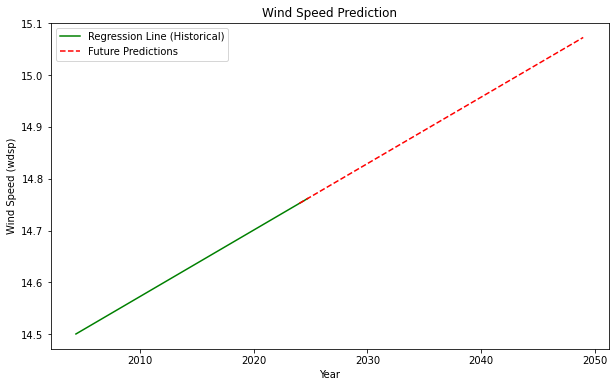

In [75]:
# Prepare the data
X = combined_wdsp_df[['fractional_year']]  # Feature: year
y = combined_wdsp_df['wdsp_donegal']    # Target: wind speed

# Train the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict wind speeds for historical data
historical_predictions = model.predict(X)

# Predict future wind speeds for 2024-2034
future_years = np.array(range(2024, 2050)).reshape(-1, 1)
future_predictions = model.predict(future_years)

# Plot the results
plt.figure(figsize=(10, 6))

# Historical data and regression line
#plt.scatter(X, y, label='Historical Data', color='blue', alpha=0.6)

plt.plot(X, historical_predictions, color='green', label='Regression Line (Historical)')

# Future predictions
plt.plot(future_years, future_predictions, color='red', linestyle='--', label='Future Predictions')

# Labels and legend
plt.xlabel('Year')
plt.ylabel('Wind Speed (wdsp)')
plt.title('Wind Speed Prediction')
plt.legend()
plt.show()


### Windfarm Locations

Data from https://data.gov.ie/dataset/wind-farms-in-ireland

Plot map of Ireland first then plot windfarm location data on top.

In [ ]:
# define the url to windfarm location data
#windfarm_url = "https://seaiopendata.blob.core.windows.net/wind/WindFarmsJune2022_ESPG3857.zip"

# define the path to the downloaded shapefile
windfarm_shp_path = "./data/WindFarmsJune2022_ESPG3857/Wind Farms June 2022_ESPG3857.shp"


Plot the map.

Ireland shapefile CRS: EPSG:2157
Windfarm locations CRS: EPSG:3857
Ireland shapefile CRS after conversion: EPSG:4326
Windfarm locations CRS after conversion: EPSG:4326


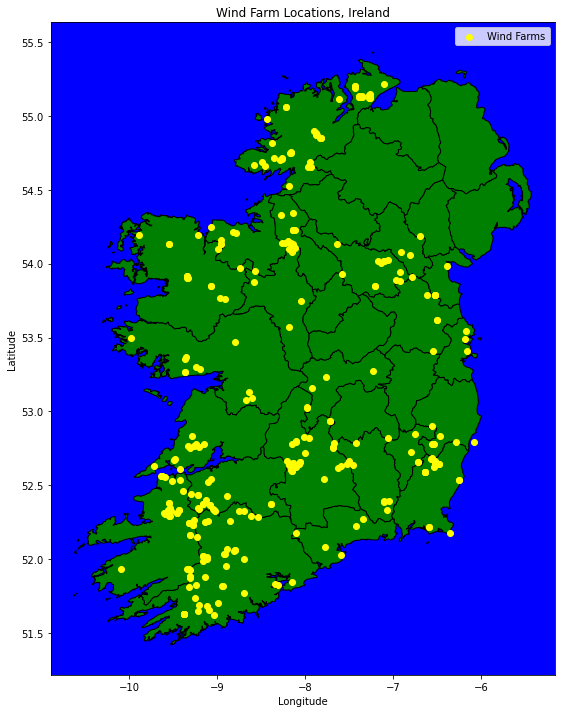

In [ ]:
# load the Ireland shapefile
main_map_path = "./data/Ireland_Shapefiles_ITM/Ireland_CountyBoundaries_ITM.shp"
main_map = gpd.read_file(main_map_path)
print(f"Ireland shapefile CRS: {main_map.crs}")

# load the windfarm locations shapefile
locations_path = "./data/WindFarmsJune2022_ESPG3857/Wind Farms June 2022_ESPG3857.shp"
locations = gpd.read_file(locations_path)
print(f"Windfarm locations CRS: {locations.crs}")


# convert both shapefiles to EPSG:4326 so we can display in Lat/Lon axes
main_map = main_map.to_crs("EPSG:4326")
locations = locations.to_crs("EPSG:4326")
print(f"Ireland shapefile CRS after conversion: {main_map.crs}")
print(f"Windfarm locations CRS after conversion: {locations.crs}")

# plot both shapefiles
fig, ax = plt.subplots(figsize=(12, 12))

# set the background color of the plot to blue
ax.set_facecolor('blue')

# plot the shapefile
main_map.plot(ax=ax, color='green', edgecolor='black')

# plot locations
locations.plot(ax=ax, color='yellow', marker='o', label='Wind Farm')

# add title, legend, labels
plt.legend()
plt.title("Wind Farm Locations, Ireland")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


***

### END